In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [2]:
# Definiamo la classe dell'autoencoder
class Autoencoder(nn.Module):
    def __init__(self, input_size, hidden_sizes):
        super(Autoencoder, self).__init__()
        encoder_layers = []
        decoder_layers = []
        prev_size = input_size

        # Costruiamo l'encoder
        for hidden_size in hidden_sizes:
            encoder_layers.append(nn.Linear(prev_size, hidden_size))
            encoder_layers.append(nn.ReLU())
            prev_size = hidden_size

        self.encoder = nn.Sequential(*encoder_layers)

        # Costruiamo il decoder (simmetrico all'encoder)
        for hidden_size in reversed(hidden_sizes):
            decoder_layers.append(nn.Linear(prev_size, hidden_size))
            decoder_layers.append(nn.ReLU())
            prev_size = hidden_size

        decoder_layers.append(nn.Linear(prev_size, input_size))
        decoder_layers.append(nn.Sigmoid())  # Sigmoid è usato per limitare l'output tra 0 e 1

        self.decoder = nn.Sequential(*decoder_layers)

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [6]:
# Creiamo dei dati random bidimensionali per l'addestramento
data_size = 100
input_rows = 17  # Numero di righe della matrice di input
input_cols = 17  # Numero di colonne della matrice di input
data = torch.randn(data_size, input_rows, input_cols)
threshold = 0.5
data = (data > threshold).float()  # Rende i dati binari

# Suddividiamo i dati in set di addestramento e test
train_data, test_data = train_test_split(data, test_size=0.3, random_state=42)

# Definiamo i parametri dell'autoencoder
hidden_sizes = [64, 64]  # Specifica il numero di strati nascosti e le loro dimensioni
learning_rate = 0.001
num_epochs = 2000
batch_size = 1000  # Dimensione del batch per il dataloader

# Imposta il dispositivo sulla GPU se disponibile, altrimenti usa la CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# sposto tutti i dati prima, se ho abbastanza memoria nella GPU per contenere tutti i dati
train_data = train_data.to(device)
test_data = test_data.to(device)

# Creiamo set di dati di addestramento e test utilizzando DataLoader
# Reshape dei dati bidimensionali in un vettore
train_data = train_data.view(train_data.shape[0], -1)
print(f"train_data shape  {train_data.shape}")
train_dataset = TensorDataset(train_data)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True) #, pin_memory=True)

test_data = test_data.view(test_data.shape[0], -1)
print(f"test_data shape  {test_data.shape}")
test_dataset = TensorDataset(test_data)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)  #, pin_memory=True)

# Creiamo l'istanza dell'autoencoder e il criterio di loss (MSE)
autoencoder = Autoencoder(input_rows * input_cols, hidden_sizes)
#criterion = nn.MSELoss()
criterion = nn.BCELoss()  # Cambiamo alla BCE loss
optimizer = optim.Adam(autoencoder.parameters(), lr=learning_rate)

# Sposta il modello e i dati sulla GPU
autoencoder.to(device)


train_data shape  torch.Size([70, 289])
test_data shape  torch.Size([30, 289])


Autoencoder(
  (encoder): Sequential(
    (0): Linear(in_features=289, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=64, bias=True)
    (3): ReLU()
  )
  (decoder): Sequential(
    (0): Linear(in_features=64, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=289, bias=True)
    (5): Sigmoid()
  )
)

In [7]:
train_losses = []
test_losses = []

for epoch in range(num_epochs):
    train_loss = 0.0
    test_loss = 0.0
    
    autoencoder.train()
    for batch in train_loader:
        batch_data = batch[0]
        output = autoencoder(batch_data)
        loss = criterion(output, batch_data)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        l = loss.item()
        train_loss += l * batch_data.size(0)

    train_loss /= len(train_loader.dataset)
    train_losses.append(train_loss)    
    
    # Valutazione sui dati di test
    autoencoder.eval()
    with torch.no_grad():
        for batch in test_loader:
            batch_data = batch[0]
            output = autoencoder(batch_data)
            loss = criterion(output, batch_data)
            l = loss.item()
            test_loss += l * batch_data.size(0)

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)
    
    if (epoch + 1) % 100 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], Train Loss: {train_loss}')

        

# Valutazione dell'autoencoder sui dati di addestramento e test
with torch.no_grad():
    reconstructed_train_data = autoencoder(train_data)
    reconstructed_test_data = autoencoder(test_data)

# Calcoliamo le loss di overfitting separatamente per i dati di addestramento e test
overfitting_loss_train = criterion(reconstructed_train_data, train_data)
overfitting_loss_test = criterion(reconstructed_test_data, test_data)
print(f'Loss di overfitting (Train): {overfitting_loss_train.item()}')
print(f'Loss di overfitting (Test): {overfitting_loss_test.item()}')

Epoch [100/2000], Train Loss: 0.5346332788467407
Epoch [200/2000], Train Loss: 0.23352916538715363
Epoch [300/2000], Train Loss: 0.02623375877737999
Epoch [400/2000], Train Loss: 0.003972471691668034
Epoch [500/2000], Train Loss: 0.0015284086111932993
Epoch [600/2000], Train Loss: 0.0008221338503062725
Epoch [700/2000], Train Loss: 0.0005179336294531822
Epoch [800/2000], Train Loss: 0.0003572518762666732
Epoch [900/2000], Train Loss: 0.0002615169214550406
Epoch [1000/2000], Train Loss: 0.00019967569096479565
Epoch [1100/2000], Train Loss: 0.00015727344725746661
Epoch [1200/2000], Train Loss: 0.0001268959604203701
Epoch [1300/2000], Train Loss: 0.00010437235323479399
Epoch [1400/2000], Train Loss: 8.720105688553303e-05
Epoch [1500/2000], Train Loss: 7.378934242296964e-05
Epoch [1600/2000], Train Loss: 6.312588811852038e-05
Epoch [1700/2000], Train Loss: 5.4508247558260337e-05
Epoch [1800/2000], Train Loss: 4.745120168081485e-05
Epoch [1900/2000], Train Loss: 4.158961746725254e-05
Epoch 

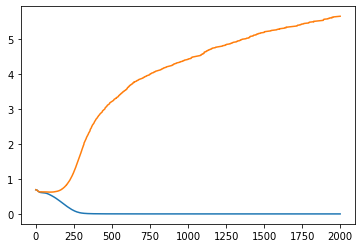

In [8]:
plt.plot(train_losses)
plt.plot(test_losses)

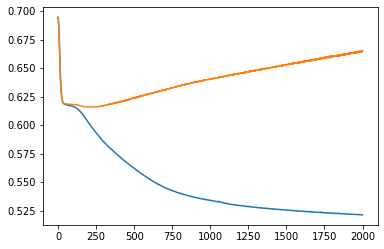

In [ ]:
# da quì in poi era MSELoss

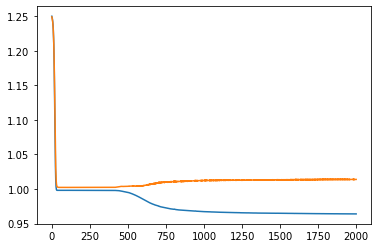

In [30]:
#con 30 nodi (lr= 0.001)

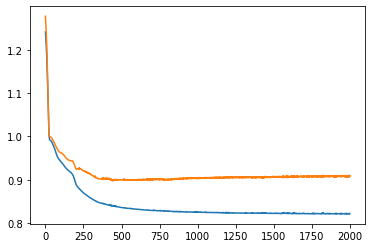

In [21]:
# con 4 nodi

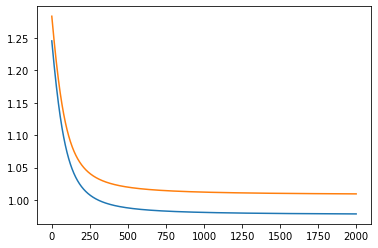

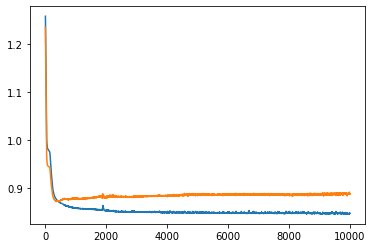

# Test con grafi ancora più random?

In [1]:
import networkx as nx
from networkx import NetworkXError
import numpy as np
import matplotlib.pyplot as plt

In [114]:
grafi1 = []
grafiCM = []
degrees1 = []
degreesCM = []
num_nodi = 200
int_random = []
#for i in range(1000):
while len(grafiCM) <= 100:
    r = np.random.randint(1,50,num_nodi)
    #print(r)
    try:
        g = nx.havel_hakimi_graph(r)
        gcc = sorted(nx.connected_components(g), key=len, reverse=True)
        gr0 = g.subgraph(gcc[0]).copy()
        grafi1.append(gr0)
        degrees1.extend(np.array(list(dict(gr0.degree()).values()) ))
        
        gcm = nx.configuration_model(r)
        grcm = nx.Graph(gcm)  # remove multiple edges
        grcm.remove_edges_from(nx.selfloop_edges(grcm))  # remove self loops
        gccmm = sorted(nx.connected_components(grcm), key=len, reverse=True)
        grcm0 = grcm.subgraph(gccmm[0]).copy()
        if len(grcm0.nodes()) == num_nodi:
            grafiCM.append(grcm0)
            degreesCM.extend(np.array(list(dict(grcm0.degree()).values()) ))
            int_random.append(r)
        
       
    except NetworkXError as e:
        pass
print(f"{len(grafi1)} grafi HK generati,  con CM: {len(grafiCM)}  è uguale perché serve comunque una sequenza grafica")

101 grafi HK generati,  con CM: 101  è uguale perché serve comunque una sequenza grafica


(array([24., 22., 14., 11., 28., 19., 18., 25., 21., 20., 18., 17., 28.,
        17., 18., 16., 16., 29., 21., 23., 22., 16., 11., 18., 21., 16.,
        20., 22., 17., 11., 24., 23.,  9., 14., 18., 18., 25., 21., 32.,
        23., 17., 23., 22., 21., 28., 20., 24., 15., 20., 24.]),
 array([3.36782844e-04, 2.03214069e-02, 4.03060310e-02, 6.02906551e-02,
        8.02752791e-02, 1.00259903e-01, 1.20244527e-01, 1.40229151e-01,
        1.60213775e-01, 1.80198399e-01, 2.00183024e-01, 2.20167648e-01,
        2.40152272e-01, 2.60136896e-01, 2.80121520e-01, 3.00106144e-01,
        3.20090768e-01, 3.40075392e-01, 3.60060016e-01, 3.80044640e-01,
        4.00029264e-01, 4.20013888e-01, 4.39998512e-01, 4.59983136e-01,
        4.79967761e-01, 4.99952385e-01, 5.19937009e-01, 5.39921633e-01,
        5.59906257e-01, 5.79890881e-01, 5.99875505e-01, 6.19860129e-01,
        6.39844753e-01, 6.59829377e-01, 6.79814001e-01, 6.99798625e-01,
        7.19783249e-01, 7.39767873e-01, 7.59752498e-01, 7.79737122e-

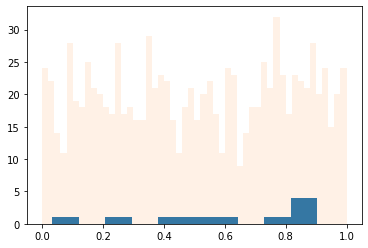

In [12]:
import numpy as np
import matplotlib.pyplot as plt
r = np.random.rand(10)
r2 = np.random.rand(1000)
plt.hist(r)
plt.hist(r2, bins=50, alpha=0.1)

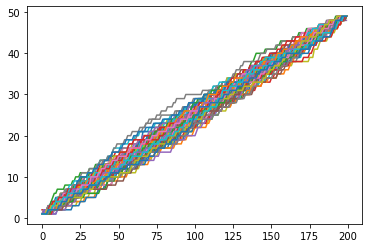

In [115]:
for i in int_random:
    plt.plot(sorted(i))

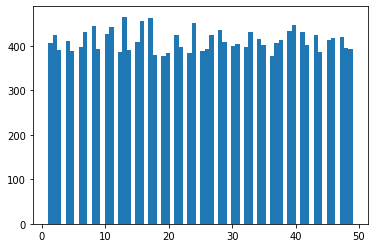

In [117]:
plt.hist(int_random, bins=70);

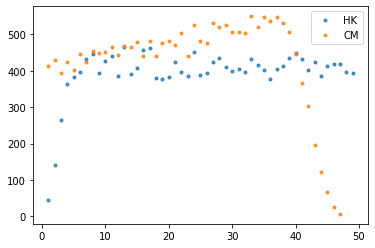

In [118]:
counts1 = np.unique(np.array(degrees1), return_counts=True)
plt.plot(*counts1, '.', alpha=0.8, label="HK");
#plt.show()
countsCM = np.unique(np.array(degreesCM), return_counts=True)
plt.plot(*countsCM, '.' , alpha=0.8, label="CM");
plt.legend()
plt.show()

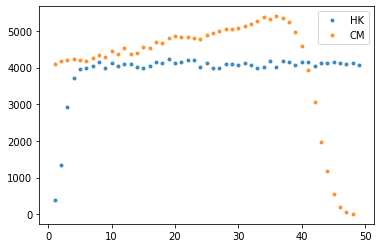

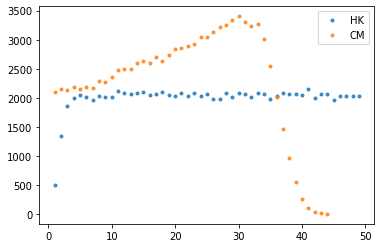

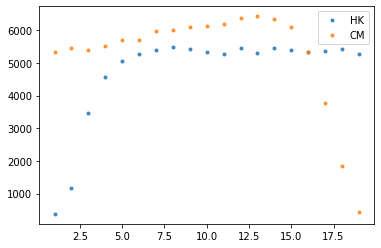

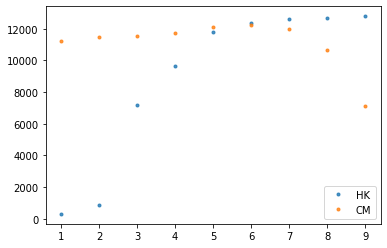

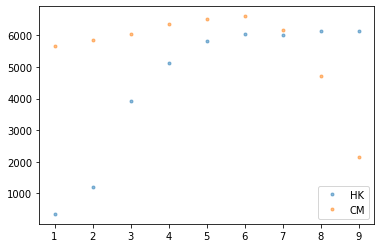

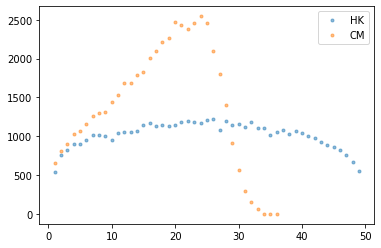

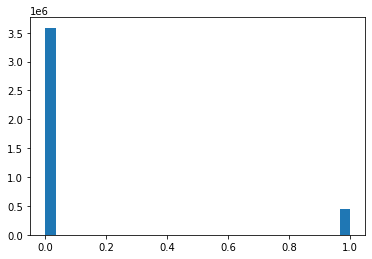

In [119]:
binary_array = np.array([nx.to_numpy_array(g).ravel() for g in grafiCM]).ravel()
plt.hist(binary_array, bins=30);

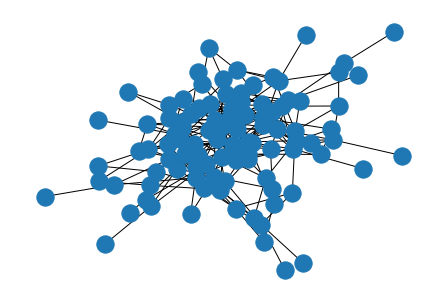

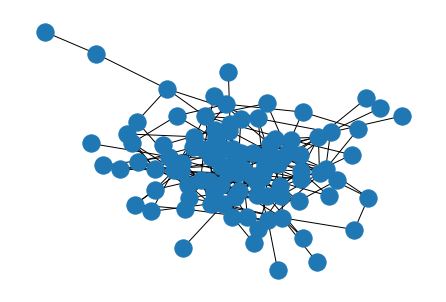

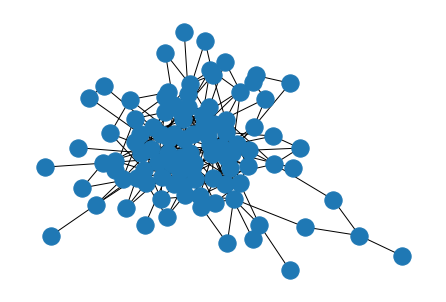

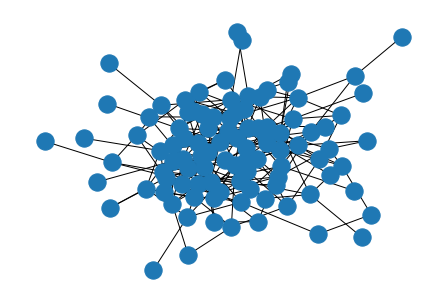

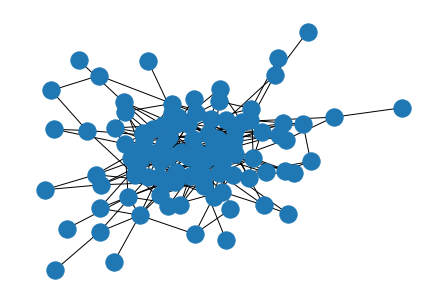

In [15]:
#for g in grafi1[:5]:
#    nx.draw(g)
#    plt.show()
for g in grafiCM[:5]: 
    nx.draw(g)
    plt.show()